# Optimisation of the Global Calculator via Monte Carlo Markov Chains

This investigation aims to generate different climate change mitigation pathways with the “Global Calculator” - a complex model used to forecast the world’s energy, food and land systems to 2050 (http://tool.globalcalculator.org/). Performing a constrained optimisation of the model’s input parameter space yields alternative pathways to sustainability. 
 
The key challenge of such an optimisation is to explore a broad parameter space (~9e50 different parameter combinations) rapidly.

The optimisation constraints can be expressed as probability distributions. MCMC can be used to find the probability distribution of each lever that maximises the probability of the output distribution. 

In this analysis, two constraints are imposed. The temperature constraint ensures compliance of the 2C warming limit while the cost constraint ensures a cost at most equal to the business as usual scenario (as described by the IEA 6DS pathway). 

In [1]:
import time 
import string
import math
import random
import csv   
from functools import reduce
from openpyxl import load_workbook

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import itertools

import selenium
from selenium import webdriver
from selenium.common.exceptions import ElementClickInterceptedException
from webdriver_manager.chrome import ChromeDriverManager

from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy import optimize
from scipy.stats import multivariate_normal

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

# Set-up

Use selenium to open Chrome and access the Global Calculator.

In [177]:
driver = webdriver.Chrome(ChromeDriverManager().install()) # set browser

[WDM] - Current google-chrome version is 84.0.4147
[WDM] - Get LATEST driver version for 84.0.4147


[WDM] - Get LATEST driver version for 84.0.4147
[WDM] - Trying to download new driver from http://chromedriver.storage.googleapis.com/84.0.4147.30/chromedriver_win32.zip
[WDM] - Driver has been saved in cache [C:\Users\44783\.wdm\drivers\chromedriver\win32\84.0.4147.30]


In [178]:
driver.get('http://tool.globalcalculator.org/') # open website

In [179]:
id_box = driver.find_element_by_id('lets-start') # bypass "Start" screen
id_box.click()

In [3]:
dfs = pd.read_excel("excel_files/Output_map.xlsx") # file mapping output lever names to xpaths 
dfs_3 = pd.read_excel("excel_files/Input_map.xlsx") # file mapping input names to xpaths 
for i in range(len(dfs)): # generate html lever addresses and put them in the dataframe
    dfs.iloc[i, 2] = '/html/body/table[1]/tbody/tr/td/table/tbody/tr[2]/td[1]/div[13]/div/table/tbody/tr[' + str(dfs.iloc[i, 1]).strip("%") + ']/td[5]/div/font' 

In [181]:
# each letter corresponds to a lever value: a = 1.0; b = 1.1; c = 1.2; ... C = 3.9; D = 4.0
lever_names = list(dfs_3.iloc[:, 0].to_numpy()) # Create list with all lever names
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D']

In [ ]:
# move_lever(lever_names, [2.9, 2.3, 2.3, 2.9, 2.7, 2.7, 2.9, 3.0, 2.8, 3.1, 2.0, 2.9, 2.7, 2.2, 1.8, 2.9, 3.0, 1.8, 1.8, 2.9, 2.3, 1.9, 1, 3.0, 3.0, 1.6, 2.7, 1.6, 2.3, 2.9, 1.9, 2.0, 3.0, 4.0, 1.8, 2.8, 2.6, 2.5, 3.0, 2.4, 3.0, 2.0, 2.7, 1, 1, 1, 1, 3.1] )

In [185]:
def open_lever_menus():
    """Opens all the lever menus of the Global Calculator"""
    for i in range(1, 16): # Iterate through menus
        try: # Tries to open the menu
            driver.find_element_by_xpath('//*[@id="ml-open-close-link-' + str(i) +  '"]' ).click() # Open menu
            time.sleep(0.3) # Server can't respond quicker than this 
        except ElementClickInterceptedException: # If opening menus too fast, then slow down
            time.sleep(1)
            driver.find_element_by_xpath('//*[@id="ml-open-close-link-' + str(i) +  '"]' ).click()
    return

def find_lever_ref(name, box = 1): 
    """Given a lever name and box position, return its XPath"""
    ref = str(dfs[dfs.iloc[:, 1].str.match(name)].iloc[0, 3]) # Get lever xpath
    ref = ref[:-2] + str(2 + box) + ref[-2 + 1:] # Adjust address for given box
    return ref

def read_lever(name): 
    """Given a lever name, return its ID"""
    pos = str(dfs[dfs.iloc[:, 1].str.match(name)].iloc[0, 2]) # Find lever ID
    return 'fb-l-' + pos 

def read_CO2():
    """For the current lever combination, return the CO2 level (GtCO2)"""
    userid_element = driver.find_element_by_xpath('//*[@id="container_dashboard_co2_budget"]') # Find element that contains CO2 value
    time.sleep(0.05)
    co2 = userid_element.text.splitlines()[-6] # Get CO2 value from the container
    return co2 

def read_outputs():
    """Reads all outputs and returns them as a list"""
    compare_box = driver.find_element_by_xpath('//*[@id="mp-nav-compare"]') # Move to the "Compare" section
    compare_box.click()
    out_vals = []
    for i in range(len(dfs)):
        userid_element = driver.find_element_by_xpath(dfs.iloc[i, 2])
        out_vals.append(float(userid_element.text.rstrip("%")))
    time.sleep(0.1)   
    try:
        driver.find_element_by_xpath('//*[@id="mn-1"]').click() 
    except: # Problem going back to the overview section? The code below sorts it
        time.sleep(0.2)
        id_box = driver.find_element_by_id('lets-start') # Bypass "Start" screen
        id_box.click()
    return out_vals

def map_to_letter(value):
    """Takes a float value in the range [1, 4.0] and returns its corresponding URL character"""
    if value != 2 and value != 3 and value != 4: # Special cases 
        if value < 4: 
            pos = int((value - 1.0)*10)
            try:
                back = letters[pos]
            except: # Oops, the value is out of bounds
                print("Not enough letters, fetching position: ", pos, " corresponding to value: ", value)
        else: # Special case: Value = 4
            back = letters[-1]
    else: 
        back = int(value)
    return back

def random_URL():
    """Generates and return a random URL (address) and its corresponding lever values (input_levers)"""
    address = []; input_levers = []
    string = "" # URL address to be stored here
    for i in range(49): # Generate a random value for each lever, map it to a letter and save it
        rand_float = random.randint(18, 32)/10 # Define bounds for random number generator (currently set to [1.8, 3.2])
        input_levers.append(rand_float); address.append(map_to_letter(rand_float)) # Store them
    address[43:47] = [1, 1, 1, 1]  # CCS values are fixed at 1 for the moment
    input_levers[43:47] = [1, 1, 1, 1] # CCS values are fixed at 1 for the moment  
    for i in address: # Construct string containing the current lever combination
        string = string + str(i)
    address = "http://tool.globalcalculator.org/globcalc.html?levers=" + string + "2211111111/technology/en" # Construct URL address
    return address, input_levers

def training_sample():
    """Generates a random training sample. It returns the input (input_levers) and output (random_output) values"""
    address, input_levers = random_URL() # Generate random URL address
    driver.get(address) # Open that URL address
    time.sleep(1) 
    id_box = driver.find_element_by_id('lets-start') # Bypass "Start now" menu
    id_box.click()
    time.sleep(0.2) 
    compare_box = driver.find_element_by_xpath('//*[@id="mp-nav-compare"]') # Move to the "Compare" section
    compare_box.click()
    random_output = read_outputs(dfs) # Read output
    return  input_levers, random_output

def log_training_sample():
    """Generate training sample and save it to a CSV file"""
    Input, Output = training_sample() # Generate random training sample
    with open(r'Training_set.csv', 'a', newline='') as f: # Append as Excel row 
        writer = csv.writer(f)
        writer.writerow(Input + Output)
    return

def find_lever_URL_position(name): 
    """Given a lever name, return its position in the URL"""
    return str(dfs_3[dfs_3.iloc[:, 0].str.match(name)].iloc[0, 1]) # Get lever position to insert in the URL

def new_URL(name, value, address = "http://tool.globalcalculator.org/globcalc.html?levers=l2wz222CBpp3pC3f2Dw3DC3plzgj1tA13pp2p223ri11111p22211111111/dashboard/en"): 
    """ 
    Generate a new URL address by changing a lever value.
        Parameters:
        - Name (string): Target lever name
        - Value (float): Target value for lever
        - Address (string): URL where lever will be changed. Set to TIAM-UCL 2DS pathway by default. 
        Returns:
        - URL (string): URL after changes. 
    """
    value = map_to_letter(value) # Map value to letter 
    index = int(find_lever_URL_position(name)) # Find URL position of given lever
    URL = address[ : 53 + index] + str(value) + address[54 + index :] # Insert given value in its corresponding URL position
    return URL 

def find_lever_sensitivities():
    """
    Analysis of climate impact sensitivity to changes in the inputs. 
    Takes the default pathway (TIAM UCL 2DS) and changes each lever value at a time (between 1.0 and 4.0), 
    reading its corresponding output. 
    """
    all_sensitivities =  np.zeros((30, len(dfs_3.iloc[:, 0]))) # Store lever sensitivities here
    col = 0 # Counter used for indexing
    for lever in dfs_3.iloc[:, 0]: # Iterate through levers, uncomment for testing:  # print("Putting lever: ", lever, " in column: ", col)
        sensitivity = []
        for i in np.linspace(1, 3.9, 30): # Move lever one increment at a time
            sensitivity.append(move_lever([lever], [round(i, 2)])) # Move lever and store CO2 value # print(sensitivity)
        all_sensitivities[:, col] = sensitivity # Append
        col += 1
        set_to_benchmark() # Reset levers to benchmark pathway
    ### Plotting routine ###
    x_lever = np.linspace(1, 3.9, 30) # X axis
    mean = 3000 # Mean threshold
    upper = mean + mean*0.05 # Upper threshold
    lower = mean - mean*0.05 # Lower threshold
    plt.figure(figsize = (20, 10))
    for i in range(48):
        plt.plot(x_lever, all_sensitivities[:, i])
    plt.title("Temperature values and thresholds")
    plt.xlabel("Lever position")
    plt.ylabel("GtCO2 per capita")
    plt.axhline(y=3000, color='b', linestyle='-') # Plot thresholds
    plt.axhline(y=lower, color='g', linestyle='--')
    plt.axhline(y=upper, color='g', linestyle='--')
    plt.ylim([2250, 3750]) 
    plt.figure(figsize = (20, 10))
    thresholds = np.zeros((48, 2))
    lever_number = 0
    for i in all_sensitivities.T: # Calculate lever values corresponding to thresholds
        temp = []
        pos = []
        count = 0
        for j in i: 
            if j<upper and j>lower:
                temp.append(j)
                pos.append(round(x_lever[count], 2))
            count += 1
        thresholds[lever_number, :] = [pos[temp.index(max(temp))], pos[temp.index(min(temp))]]
        plt.plot(pos, temp)
        plt.title("Temperature values within thresholds")
        plt.xlabel("Lever position")
        plt.ylabel("GtCO2 per capita")
        lever_number+=1
    plt.figure(figsize = (20, 20))
    count = 0 
    for i in thresholds:
        plt.plot(np.linspace(i[0], i[1], 10), np.linspace(count, count, 10))
        count += 1
        plt.yticks(np.arange(48), list(dfs_3.iloc[:, 0].to_numpy()), fontsize = 20)
    plt.title("Lever ranges that meet temperature thresholds")
    plt.xlabel("Value range")
    plt.ylabel("Lever")
    ### End of plotting routine ### 
    return thresholds

def lever_step(lever_value, thresholds):
    """Naive modification of the Metropolis Hastings algorithm - moves a lever randomly up or down by 0.1. Return the new lever value"""
    move = -0.
    prob = random.randint(0, 100)/100 # Generate random number
    if prob < 0.5: move = -0.1 # Move lever down
    else: move = 0.1 # Move lever up
    # If the lever value is out of bounds, reverse direction of step
    if (lever_value + move < thresholds[0]) or (lever_value + move > thresholds[1]):
        move = -move
    return round(lever_value + move, 3)

def cost_sensitivity():
    """
    Analysis of GDP sensitivity to changes in the inputs. 
    Sets all levers to 2 and moves each lever to 3 at a time,
    reading its corresponding output. 
    """
    for lever in dfs_3.iloc[:, 0]: # Set all levers to 2
        move_lever([lever], [2])
    costs_sensitivity =  [] 
    for lever in dfs_3.iloc[:, 0]: # Move each lever to 3 at a time
        print("Moving lever: ", lever)
        costs_temp = move_lever([lever], [3], costs = True)[1]
        costs_sensitivity.append(costs_temp)
        print("Marginal cost: ", costs_temp)
        print("Returning lever back to normal... \n")
        move_lever([lever], [2], costs = False) # Put the lever back to 2

    reference = move_lever(['Calories consumed'], [2], costs = True)[1] # Read the benchmark cost
    data = {'Lever': list(dfs_3.iloc[:, 0].to_numpy()), # Dictionary containing costs and lever names 
            'Marginal cost': costs_sensitivity
            }

    costs_df = pd.DataFrame(data, columns = ['Lever', 'Marginal cost']) # Put cost values into dataframe
    costs_df = costs_df.sort_values(by=['Marginal cost'], ascending = False) # Sort costs
    costs_df.iloc[0, 1] = -0.08 # Truncate first value (very high, reverses direction of GDP, leading to bug)
    costs_df = costs_df.sort_values(by=['Marginal cost'], ascending = False)
    costs_df.iloc[-1, 1] = 0.46
    costs_df = costs_df.sort_values(by=['Marginal cost'], ascending = True)
    costs_df['Marginal cost'] = costs_df['Marginal cost'] - reference # Calculate cost change wrt benchmark
    ### Plotting routine ### 
    plt.figure(figsize = (20, 10)) 
    plt.xticks(rotation=45, horizontalalignment='right')
    plt.bar(costs_df.iloc[:, 0], costs_df.iloc[:, 1])
    plt.ylabel("$\Delta$GDP decrease")
    plt.title("∆GDP decrease with respect to TIAM-UCL 2DS benchmark pathway – Moving each lever from 2 to 3")
    ### End of plotting routine ###
    return

def set_to_benchmark():
    """Set Global Calculator to TIMA-UCL 2DS's benchmark pathway"""
    driver.get('http://tool.globalcalculator.org/globcalc.html?levers=l2wz222CBpp3pC3f2Dw3DC3plzgj1tA13pp2p223ri11111p22211111111/dashboard/en')
    id_box = driver.find_element_by_id('lets-start') # Bypass "Start now" screen
    id_box.click()
    return

def random_lever_value(lever_name):
    """Moves a given lever (lever_name) to a random position between 1 and 3.9"""
    rand_val = random.randint(10, 39)/10 # Generate random value between 1 and 3.9
    return move_lever([lever_name], [round(rand_val, 2)], costs = True) # Move lever and return CO2 and GDP values

def new_lever_combination():
    """Returns an array containing a random value for each lever"""
    random_lever_values = []
    for i in range(len(lever_names)):
        random_lever_values.append(random.randint(10, 39)/10) # Generate random lever value
    return random_lever_values

def generate_mu_proposal_2D(all_levers_current, all_thresholds, address = str(driver.current_url)):
    """Used in MCMC. Takes arrays containing all current values and thresholds and generates a new mu proposal"""
    for i in range(len(lever_names)): # Take discrete MH step for each lever
        all_levers_current[i] = lever_step(all_levers_current[i], all_thresholds[i])    
    # Pass list with all lever names and current values. Read temperature and costs. 
    output = move_lever(lever_names, all_levers_current, costs = True, address = address)
    
    return all_levers_current, output

def multi_sampler_2D(observations, all_levers_current, all_thresholds, samples=4, mu_init=[3000, 0.5], plot=False, mu_prior_mu=[3100, 1], mu_prior_sd=[[200, 0],[0, 0.3]], imprimir = False):
    """
    Implementation of a variant of Markov Chain Monte-Carlo (MCMC). Given some prior 
    information and a set of observations, this function performs MCMC. It calculates the posterior
    distribution of temperature and cost values and the lever values used in doing so.
    
    Parameters:
        - observations (list of lists (N x 2)): Contains temperature and cost values. 
        - all_levers_current (list): Current values of input levers. 
        - all_thresholds (list of lists (48 x 2)): Each entry contains an upper and lower bound for each lever. 
        - samples (int): Number of MCMC steps. 
        - mu_init (list): Initial guess of temperature and cost values. 
        - plot (boolean): Flag used for plotting.
        - mu_prior_mu (list): Mean temperature and cost values of prior distribution (assummed Gaussian).
        - mu_prior_sd (list of lists (2 x 2)): Diagonal matrix containing the standard deviation of the 2D prior.
        - imprimir (boolean): Flag used for printing useful information. 
    Returns:
        - posterior (list of lists (N x 2)): Contains trace of all temperature and cost values. 
        - accepted (list): Contains all the lever values corresponding the proposal accepted by MCMC. 
        - rate (list): Contains the probability of each temperature and cost pair proposal. 
        - accepted_values (list of lists (M x 2)): Contains accepted temperature and cost values.     
    """
    # Initialisations
    mu_current = mu_init # Set the current temperature and cost value 
    posterior = [mu_current] # First value of the trace
    accepted = []; accepted_values = []; rate = [] 
    address = str(driver.current_url) # Get current URL (website must be TIAM-UCL's 2DS pathway)
    
    # Perform an MCMC step
    for i in range(samples): 
        all_levers_temp = all_levers_current.copy() # Store current lever combination in a temp variable
        
        # Moves the calculator's levers using the sampler. Reads their corresponding temperature and cost values (proposal).
        all_levers_current, mu_proposal = generate_mu_proposal_2D(all_levers_current, all_thresholds, address = address)

        # Compute likelihood ratio of proposed temperature and cost values
        likelihood_ratio = np.prod(multivariate_normal(mu_proposal, [[1000000, 0],  [0, 100]]).pdf(observations) / multivariate_normal(mu_current, [[1000000, 0], [0, 100]]).pdf(observations))
        
        # Compute the prior probability ratio of the proposed temperature and cost values   
        prior_ratio = multivariate_normal(mu_prior_mu, mu_prior_sd).pdf(mu_proposal) /multivariate_normal(mu_prior_mu, mu_prior_sd).pdf(mu_current)    

        # Probability of accepting the proposal
        p_accept = likelihood_ratio*prior_ratio
        rate.append(p_accept)
        
        # Printing routine
        if imprimir == True:
            print("Iteration: ", i, "Current: ", mu_current, " Proposal: ", mu_proposal)
            print("Likelihood ratio: ", likelihood_ratio, "Prior ratio: ", prior_ratio, "Acceptance probability: ", p_accept, "\n")
        
        # Decide whether to accept or reject the temperature and cost values proposal
        accept = np.random.rand() < p_accept
        
        # Temperature and cost values accepted
        if accept: 
            address = str(driver.current_url) # Change URL address to current lever values (otherwise it remains the same)
            mu_current = mu_proposal # Update current temperature and cost values
            accepted = accepted[:].copy() + [all_levers_current.copy()] # Save accepted combination of lever values
            accepted_values.append(mu_current.copy()) # Save accepted temperature and cost values
            
        # Temperature and cost values rejected
        else: 
            all_levers_current = all_levers_temp.copy() # Return lever values to last accepted iteration
            
        # Update trace of temperature and cost values
        posterior.append(mu_current.copy()) 
        
    return posterior, accepted, rate, accepted_values

def move_lever(lever, value, costs = False, address = str(driver.current_url)): 
    """
    Sets a lever to a given value. Reads corresponding temperature and, if selected, cost values. 
    Parameters:
        - lever (list of strings): Contains the names of the levers to be moved. 
        - value (list of floats): Contains the value of the levers to be moved - Automatically matched to lever names. 
        - costs (optional, boolean): Flag to decide whether to read cost values or not. 
        - address (optional, string): URL address corresponding to given lever combination. 
    """
    # Update URL address with input lever names and values, one at a time 
    for i in range(len(lever)):
        address = new_URL(lever[i], value[i], address = address)  
        
    # Open website corresponding to the input values
    driver.get(address) 
    
    ########################################## IMPORTANT ####################################################
    # All of the lines below are in charge of webscraping the temperature and, if selected, the cost values. 
    # The Global Calculator is a hard to webscrape website (sometimes, it results in bugs or uncoherent
    # temperature and cost values). The code below ensures that, no matter what, the values will be read. 
    # To do so it performs different actions based on the current state of the website and the output values. 
    #########################################################################################################
    
    time.sleep(0.2)
    id_box = driver.find_element_by_id('lets-start') # Bypass "Start" screen
    id_box.click()
    time.sleep(1)
    
    # Read temperature values
    try:
        output = int(read_CO2()[:4]) # Read output CO2
    except: # Problem reading output CO2? The code below sorts it
        time.sleep(1)
        open_lever_menus() # Open lever menus
        move_lever([lever[0]],[1.3], costs = False) # Move lever to an arbitrary value
        driver.get(address) # Open website back 
        time.sleep(0.2)
        id_box = driver.find_element_by_id('lets-start') # Bypass "Start" screen
        id_box.click()
        output = int(read_CO2()[:4]) # Read output CO2
        
    # Read cost values   
    if costs == True:   
        driver.find_element_by_xpath('//*[@id="mn-6"]').click() # Move to compare tab 
        time.sleep(0.1)
        userid_element = driver.find_element_by_xpath('//*[@id="container_costs_vs_counterfactual"]/div/div[11]') # Read GDP
        cost_output = userid_element.text
        try:
            cost_output = float(cost_output[:4].rstrip("%")) # Convert GDP from string to float
        except: # Problem converting GDP? The code below sorts it
            cost_output = float(cost_output[:3].rstrip("%"))
        
        # Reload the page and bypass start
        driver.refresh() # Refresh
        time.sleep(1)
        id_box = driver.find_element_by_id('lets-start') # Bypass "Start" screen
        id_box.click()
        userid_element = driver.find_element_by_xpath('//*[@id="container_costs_vs_counterfactual"]/div/div[12]') # Read text below GDP value
        cost_flag = userid_element.text   
        
        # Find sign of GDP (less expensive => increase; more expensive => decrease)
        if cost_flag == 'less expensive': 
            cost_output = -cost_output # Reverse sign
            
        # Go back to the overview section
        try:
            driver.find_element_by_xpath('//*[@id="mn-1"]').click() 
        except: # Problem going back to the overview section? The code below sorts it
            time.sleep(0.2)
            id_box = driver.find_element_by_id('lets-start') # Bypass "Start" screen
            id_box.click()
        output = [output, cost_output] # Output temperature and cost values
    return  output
    
def save_all():
    """Save all accepted lever combinations, temperature and cost values, trace and probability values to a .XLSX file"""
    df1 = pd.DataFrame(np.array(posterior[:-1])); # Dataframe with posterior
    df1['2'] = rate # Append rate to it
    writer = pd.ExcelWriter('excel_files/MCMC_output_1.xlsx', engine='openpyxl') # Open Excel file
    writer.book = load_workbook('excel_files/MCMC_output_1.xlsx') # Load current workbook
    writer.sheets = dict((ws.title, ws) for ws in writer.book.worksheets) # Load all sheets
    reader = pd.read_excel(r'excel_files/MCMC_output_1.xlsx') # Read current file 
    df1.to_excel(writer,index=False,header=False,startrow=len(reader)+1) # Write out the new sheet
    writer.close() # Close Excel file
    df2 = pd.DataFrame(np.array(accepted_inputs));  # Dataframe with accepted lever combinations
    df2['48'] = np.array(accepted_values)[:, 0]; df2['49'] = np.array(accepted_values)[:, 1]; # Append accepted temperature and cost values 
    writer = pd.ExcelWriter('excel_files/MCMC_output_2.xlsx', engine='openpyxl') # Open Excel file
    writer.book = load_workbook('excel_files/MCMC_output_2.xlsx') # Load current workbook
    writer.sheets = dict((ws.title, ws) for ws in writer.book.worksheets) # Load all sheets
    reader = pd.read_excel(r'excel_files/MCMC_output_2.xlsx') # Read current file 
    df2.to_excel(writer,index=False,header=False,startrow=len(reader)+1) # Write out the new sheet
    writer.close() # Close Excel file
    return
    
def set_lever(target, lever_name):   
    """Set a given lever (lever_name) to a value (target) by clicking on it - Using a minimum number of clicks."""
    n_clicks = 0 # Set to 0 by default (<=> do nothing)
    current = driver.find_element_by_id(read_lever(lever_name)) # Get lever id 
    current = float(current.get_attribute('textContent')) # Read current lever value

    # Two possibilities: same box, or different box
    jump = math.trunc(target) - math.trunc(current)
    diff = target - current
    
    # If the lever is already set
    if target == current:
        # print("Current value = Target value")
        box_number = math.trunc(current)
        
    # Same box -> 2 possibilities: up or down (down can hit boundary or not)
    elif jump == 0:
        #print("Same box case")
        
        # Up 
        # Non boundary 
        box_number = math.trunc(current) + 1 # Current box
        if diff > 0:
            #print("Lever up")
            #print("Non boundary")
            n_clicks = int(((current - math.trunc(current)) + (math.trunc(target) + 1 - target))*10) 

        # Down
        elif diff < 0:
            #print("Lever down")
            
            # Non boundary 
            if target%math.trunc(target) != 0:
                #print("Non boundary")
                n_clicks = int(round(abs(diff*10)))

            # Boundary: click previous level, then current  
            else:
                #print("Boundary")
                n_clicks = 0 # Clicking done here (do not click later on)
                
                # Watch out for boundary case: box number 1
                if math.trunc(current) == 1: 
                    #print("Special case = 1")
                    userid_element = driver.find_elements_by_xpath(find_lever_ref(lever_name, box = 1))[0]  
                    userid_element.click()
                    
                else: 
                    userid_element = driver.find_elements_by_xpath(find_lever_ref(lever_name, box = box_number - 1))[0]  
                    userid_element.click()
                    
    # Different box -> 2 possibilities: up or down (each can be boundary or non boundary)
    elif jump != 0:
        #print ("Different box case")
        box_number = math.trunc(current) + 1 # Current box (default)
        # Up 
        if diff > 0:
            #print("Lever up")
            
            # Boundary 
            if target%math.trunc(target) == 0:
                if jump == 1: 
                    #print("Special case - Different box, boundary closest box")
                    userid_element = driver.find_elements_by_xpath(find_lever_ref(lever_name, box = box_number+1))[0]
                    userid_element.click()
                    box_number = target
                    n_clicks = 1
                else:    
                    #print("Boundary")
                    box_number = target
                    n_clicks = 1
                
       # Non boundary
            else:
                #print("Non boundary")
                box_number = math.trunc(target) + 1
                userid_element = driver.find_elements_by_xpath(find_lever_ref(lever_name, box = box_number))[0]
                userid_element.click()
                n_clicks = int(round((math.trunc(target) + 1 - target)*10))

        # Down
        elif diff < 0:
            #print("Lever down")
            
            # Boundary 
            if target%math.trunc(target) == 0:
                #print("Boundary")
                box_number = target
                n_clicks = 1

            # Non boundary 
            else:
                #print("Non boundary")
                box_number = math.trunc(target) + 1
                userid_element = driver.find_elements_by_xpath(find_lever_ref(lever_name, box = box_number))[0]
                userid_element.click()
                n_clicks = int(round((math.trunc(target) + 1 - target)*10))

    userid_element = driver.find_elements_by_xpath(find_lever_ref(lever_name, box = box_number))[0]    
    #print("Number of clicks: ", n_clicks)
    for i in range(n_clicks):
        userid_element.click()
    time.sleep(0.25)
    print("CO2 emissions: ", read_CO2(), " \t Meets 2C target?", int(read_CO2()[:4]) < 3010)
    driver.find_element_by_xpath('/html/body/table[1]/tbody/tr/td/table/tbody/tr[1]/td/table/tbody/tr[1]/td[1]').click()
    # move mouse away to avoid collisions
    return

In [9]:
random_lever_values = new_lever_combination() # Generate random lever combination
temp = move_lever(lever_names, random_lever_values, costs = True) # Move lever accordingly

In [ ]:
temp_sensitivity = []
costs_sensitivity =  [] 
for lever in dfs_3.iloc[:, 0]: # Move each lever to 3 at a time
    address = str(driver.current_url)
    print("Moving lever: ", lever)
    costs_temp = move_lever([lever], [3], costs = True, address = address)
    costs_sensitivity.append(costs_temp[1])
    temp_sensitivity.append(costs_temp[0])
    print("Marginal cost: ", costs_temp)
    print("Returning lever back to normal... \n")
    move_lever([lever], [2], costs = False, address = address) # Put the lever back to 2

reference = move_lever(['Calories consumed'], [2], costs = True)[1] # Read the benchmark cost
data = {'Lever': list(dfs_3.iloc[:, 0].to_numpy()), # Dictionary containing costs and lever names 
        'Marginal cost': costs_sensitivity
        }



In [256]:
data = {'Lever': list(dfs_3.iloc[:, 0].to_numpy()), # Dictionary containing costs and lever names 
        'Marginal cost': costs_sensitivity
        }



In [257]:
costs_df = pd.DataFrame(data, columns = ['Lever', 'Marginal cost']) # Put cost values into dataframe
costs_df = costs_df.sort_values(by=['Marginal cost'], ascending = True) # Sort costs

In [258]:
costs_df.iloc[1, 1] = 1.24
costs_df.iloc[0, 1] = -0.21

In [259]:
costs_df = costs_df.sort_values(by=['Marginal cost'], ascending = True) # Sort cost
costs_df.iloc[:, 1]  = costs_df.iloc[:, 1]*(-1) 

# Temperature sensitivity analysis

In [10]:
# find_lever_sensitivities() # Disabled by default (takes a while)

Text(0.5, 1.0, 'Decrease in GHG emissions per capita to 2050 – All levers set to 2, moving each lever from 2 to 3')

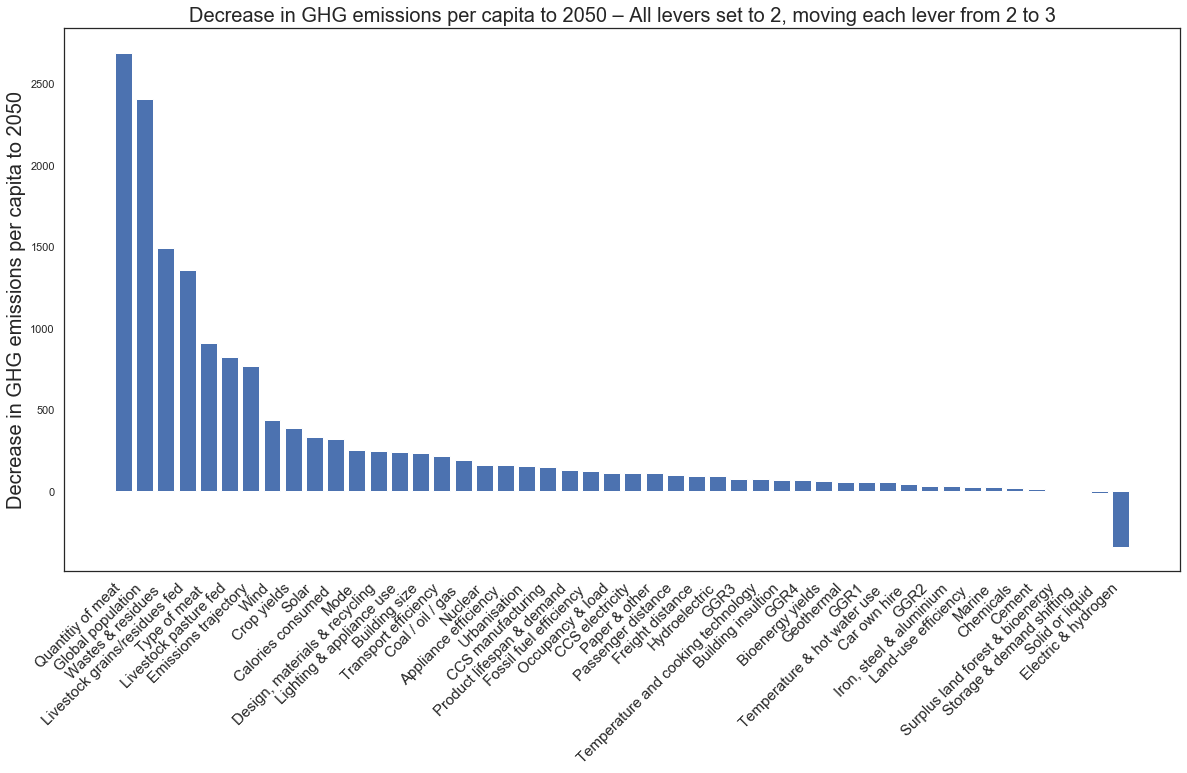

In [255]:
### Plotting routine ### 
plt.figure(figsize = (20, 10)) 
plt.xticks(rotation=45, horizontalalignment='right', fontsize = 15)
plt.bar(costs_df.iloc[:, 0], costs_df.iloc[:, 1])
plt.ylabel("Decrease in GHG emissions per capita to 2050", fontsize = 20)
plt.title("Decrease in GHG emissions per capita to 2050 – All levers set to 2, moving each lever from 2 to 3", fontsize = 20)

# Cost sensitivity analysis

In [11]:
# cost_sensitivity() # Disabled by default (takes a while)

Text(0.5, 1.0, 'Increase in GDP wrt business as usual pathway – All levers set to 2, moving each lever from 2 to 3')

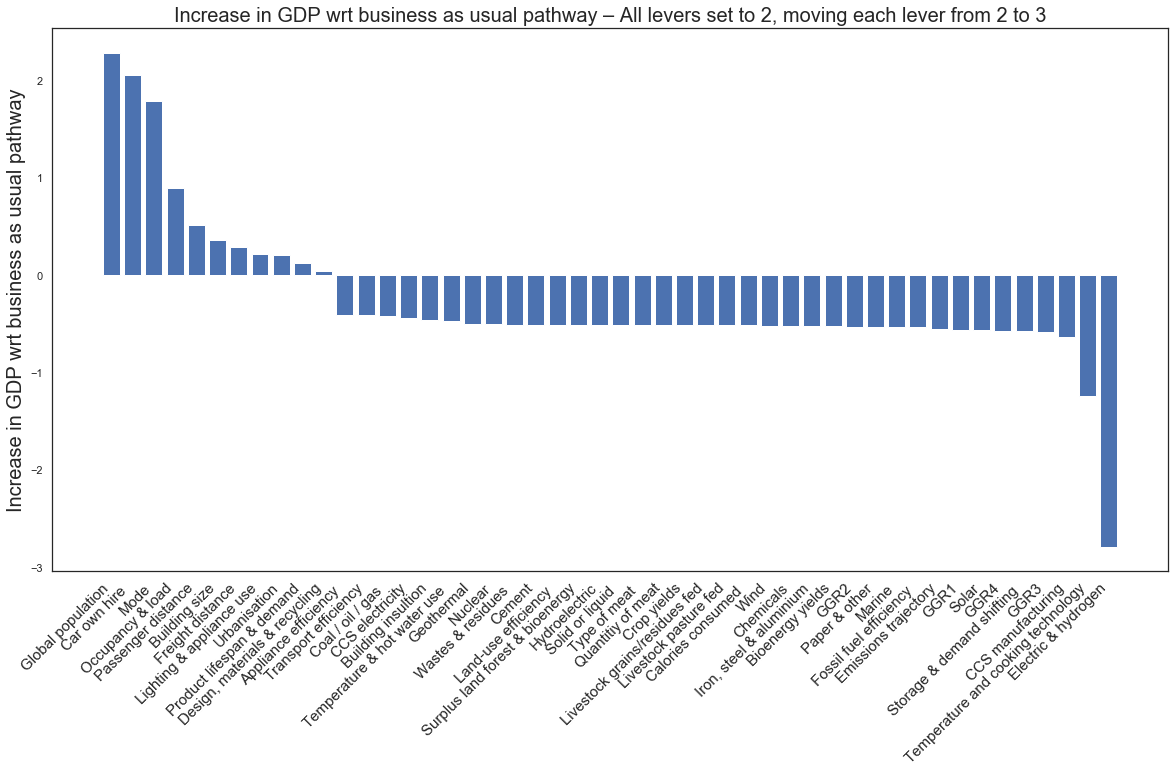

In [260]:
### Plotting routine ### 
plt.figure(figsize = (20, 10)) 
plt.xticks(rotation=45, horizontalalignment='right', fontsize = 15)
plt.bar(costs_df.iloc[:, 0], costs_df.iloc[:, 1])
plt.ylabel("Increase in GDP wrt business as usual pathway", fontsize = 20)
plt.title("Increase in GDP wrt business as usual pathway – All levers set to 2, moving each lever from 2 to 3", fontsize = 20)

# Generalising MCMC (2 constraints) to all levers

## Unbounded prior for all levers

In [ ]:
lever_names = list(dfs_3.iloc[:, 0].to_numpy()) # Create list with all lever names
lever_values = []
for i in range(300): # Draw 300 samples from the prior 
    random_lever_values = new_lever_combination() # Generate random lever combination
    temp = move_lever(lever_names, random_lever_values, costs = True) # Move lever accordingly
    if (temp[0] > 1000) and (temp[1]>-14): # Check for spurious values
        lever_values.append(temp)

In [ ]:
# Change format of prior values: from data pairs to separate lists of observations
x_val = []; y_val = []
for i in lever_values: 
    x_val.append(i[0]); y_val.append(i[1])
lever_values = [x_val, y_val]

In [65]:
# Calculate mean and standard deviation of the randomly sampled temperature and cost values
mu_1, mu_2, sigma_1, sigma_2 = np.mean(lever_values[0]), np.mean(lever_values[1]), 10*np.std(lever_values[0]), 10*np.std(lever_values[1])

# Values below are a good approximation
#mu_1, mu_2, sigma_1, sigma_2 = (3436.1744680851066, -2.639191489361702, 18204.97972378225, 34.59578098974829)

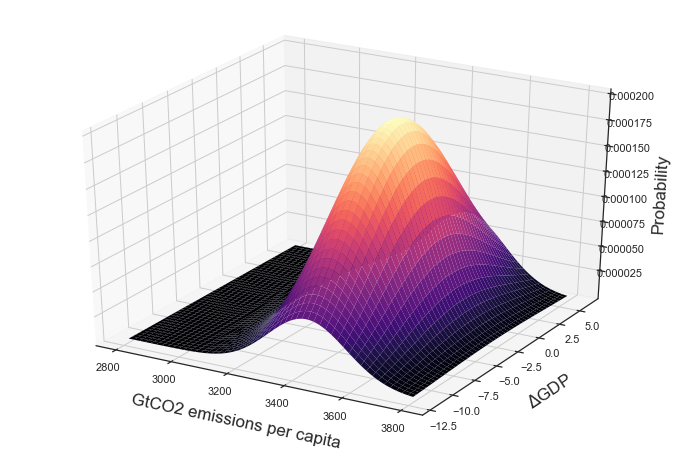

In [96]:
# Parameters to set
mu_x ,variance_x, mu_y, variance_y = mu_1, sigma_1, mu_2, sigma_2

# Create grid and multivariate normal
x = np.linspace(2800,3800,500)
y = np.linspace(-12,6,500)
X, Y = np.meshgrid(x,y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
rv = multivariate_normal([mu_x, mu_y], [[variance_x, 0], [0, variance_y]])

# 3D plot
fig = plt.figure(figsize = (12, 8))
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, rv.pdf(pos), cmap='magma',linewidth=0)
ax.set_xlabel('\n' + 'GtCO2 emissions per capita', linespacing=2)
ax.set_ylabel('\n' +'$\Delta$GDP', linespacing=2)
ax.set_zlabel('\n' +'Probability', linespacing=2)
plt.show()

Text(0, 0.5, '$\\Delta$GDP')

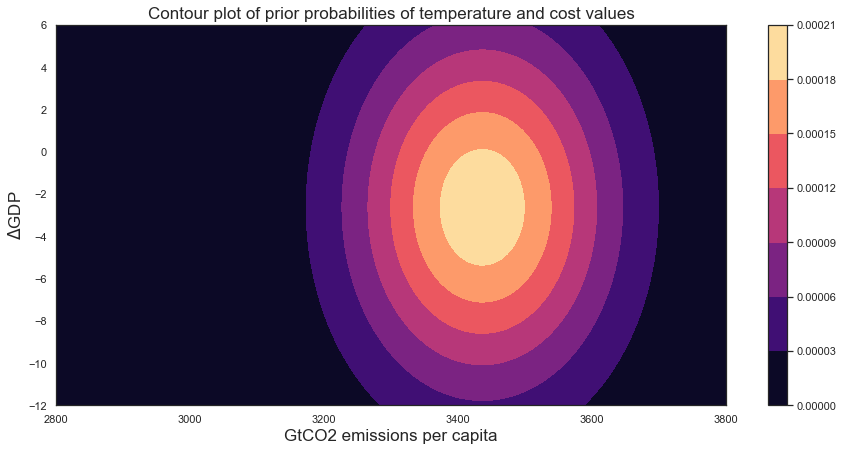

In [99]:
fig = plt.figure(figsize=(15, 7))
ax0 = fig.add_subplot(111)
axis = ax0.contourf(X, Y, rv.pdf(pos),cmap='magma')
fig.colorbar(axis)
plt.title("Contour plot of prior probabilities of temperature and cost values")
plt.xlabel("GtCO2 emissions per capita")
plt.ylabel("$\Delta$GDP")

## Generating observations 

In [123]:
# Draw random normal temperature value
temp_vals = np.random.normal(2850, 150, 10000)
# Draw random normal cost value
cost_vals = np.random.normal(0, 1, 10000)

Text(0, 0.5, 'Probability')

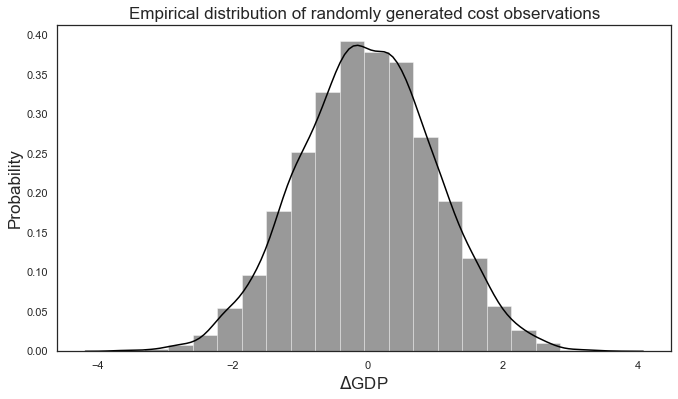

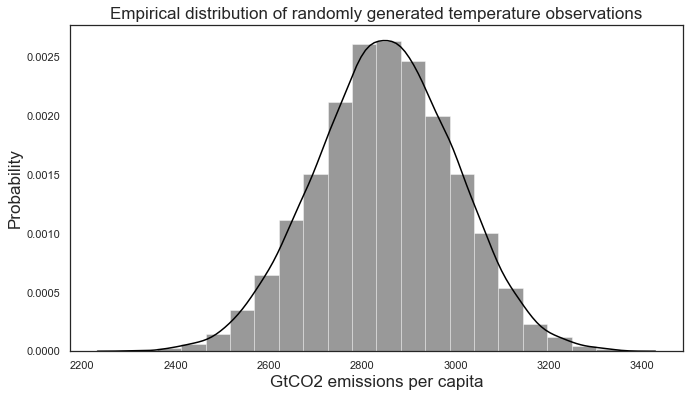

In [124]:
plt.figure(figsize = (11, 6)); 
sns.distplot(cost_vals, color = "black", bins = 20); 
plt.title("Empirical distribution of randomly generated cost observations")
plt.xlabel("$\Delta$GDP")
plt.ylabel("Probability")
plt.figure(figsize = (11, 6));  
sns.distplot(temp_vals, color = "black", bins = 20)
plt.title("Empirical distribution of randomly generated temperature observations")
plt.xlabel("GtCO2 emissions per capita")
plt.ylabel("Probability")

## Defining a likelihood function

Text(0.5, 1.0, 'Temperature and cost observations and contours of likelihood function')

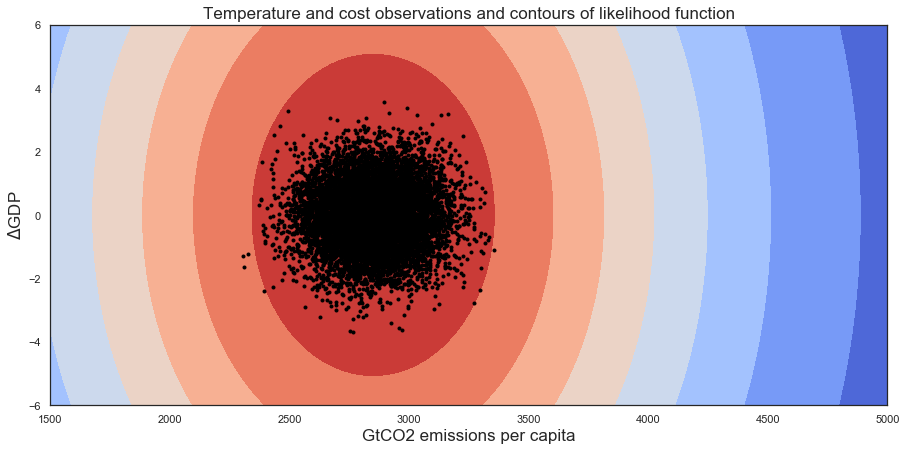

In [167]:
# The parameters below have been empirically adjusted to obtain a reasonable MCMC convergence with optimal acceptance rate
mu_x, variance_x, mu_y, variance_y = 2850, 1000000, 0, 100

# Create grid and multivariate normal
x = np.linspace(1500, 5000,500)
y = np.linspace(-6,6,500)
X, Y = np.meshgrid(x,y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
rv = multivariate_normal([mu_x, mu_y], [[variance_x, 0], [0, variance_y]])

# 3D plot
fig = plt.figure(figsize=(15, 7))
ax0 = fig.add_subplot(111)
ax0.contourf(X, Y, rv.pdf(pos),cmap='coolwarm')
for i in range(len(temp_vals)):
    plt.plot(temp_vals[i], cost_vals[i], '.', color = 'black')
plt.ylabel("$\Delta$GDP")
plt.xlabel("GtCO2 emissions per capita")
plt.title("Temperature and cost observations and contours of likelihood function")

In [22]:
# Construct observations array (as pairs of data)
observations = [list(temp_vals), list(cost_vals)]
observations = [] 
for i in range(len(temp_vals)):
    observations.append([temp_vals[i], cost_vals[i]])

# Running MCMC and logging results 

In [ ]:
# Run MCMC for 7000 (700x10) samples. Save results after every 700 samples. 
for i in range(10):
    
    # Initial lever values (corresponding to UCL TIAM 2DS pathway)
    set_to_benchmark() 
    initial_values = [2.1, 2.0, 3.2, 3.5, 2.0, 2.0, 2.0, 3.8, 3.7, 2.5, 2.5, 3.0, 2.5, 3.8, 3.0, 1.5, 2.0, 3.9, 3.2, 3.0, 3.9, 3.8, 2.1, 3.0, 2.5, 3.5, 1.6, 1.9, 1.0, 2.9, 3.6, 1.0, 3.0, 2.5, 2.5, 2.0, 2.0, 2.0, 2.5, 3.0, 2.7, 1.8, 2.5, 1.0, 1.0, 1.0, 1.0, 2.0]
    
    # Run MCMC
    try: 
        posterior, accepted_inputs, rate, accepted_values = multi_sampler_2D(observations, initial_values, no_thresholds, samples=700, mu_init=[2400, -6], mu_prior_mu=[mu_1, mu_2], mu_prior_sd=[[sigma_1,0], [0, sigma_2]], plot=False, imprimir = True);
    
    # If there is a problem with the website and the algorithm breaks, restart and try again
    except: 
        print("Broke in iteration: ", i)
        set_to_benchmark()  
        
    # Save all values
    save_all()

# Loading pre-computed results (24-hours long Markov Chain)

In [27]:
# Read output values
dfs_4 = pd.read_excel("excel_files/MCMC_output_2.xlsx") # file mapping lever names to xpaths

In [28]:
# Rearrange lever names - Not fully ordered by default 
lever_names = list(dfs_3.iloc[:, 0].to_numpy())
lever_names.remove('Product lifespan & demand')
lever_names.insert(12,'Product lifespan & demand')
dfs_4 = pd.concat([dfs_4.iloc[:, :12], dfs_4.iloc[:, 15], dfs_4.iloc[:, 12:15], dfs_4.iloc[:, 16:]], axis = 1)

In [31]:
dfs_4.columns.values[0:48] = lever_names

# Correlation matrix of accepted MCMC lever combinations

In [34]:
import matplotlib

In [157]:
def NonLinCdict(steps, hexcol_array):
    cdict = {'red': (), 'green': (), 'blue': ()}
    for s, hexcol in zip(steps, hexcol_array):
        rgb =matplotlib.colors.hex2color(hexcol)
        cdict['red'] = cdict['red'] + ((s, rgb[0], rgb[0]),)
        cdict['green'] = cdict['green'] + ((s, rgb[1], rgb[1]),)
        cdict['blue'] = cdict['blue'] + ((s, rgb[2], rgb[2]),)
    return cdict

hc = ['#b30000', '#ffffff', '#002db3']
th = [0, 0.5,  1]

cdict = NonLinCdict(th, hc)
cm = matplotlib.colors.LinearSegmentedColormap('test', cdict)


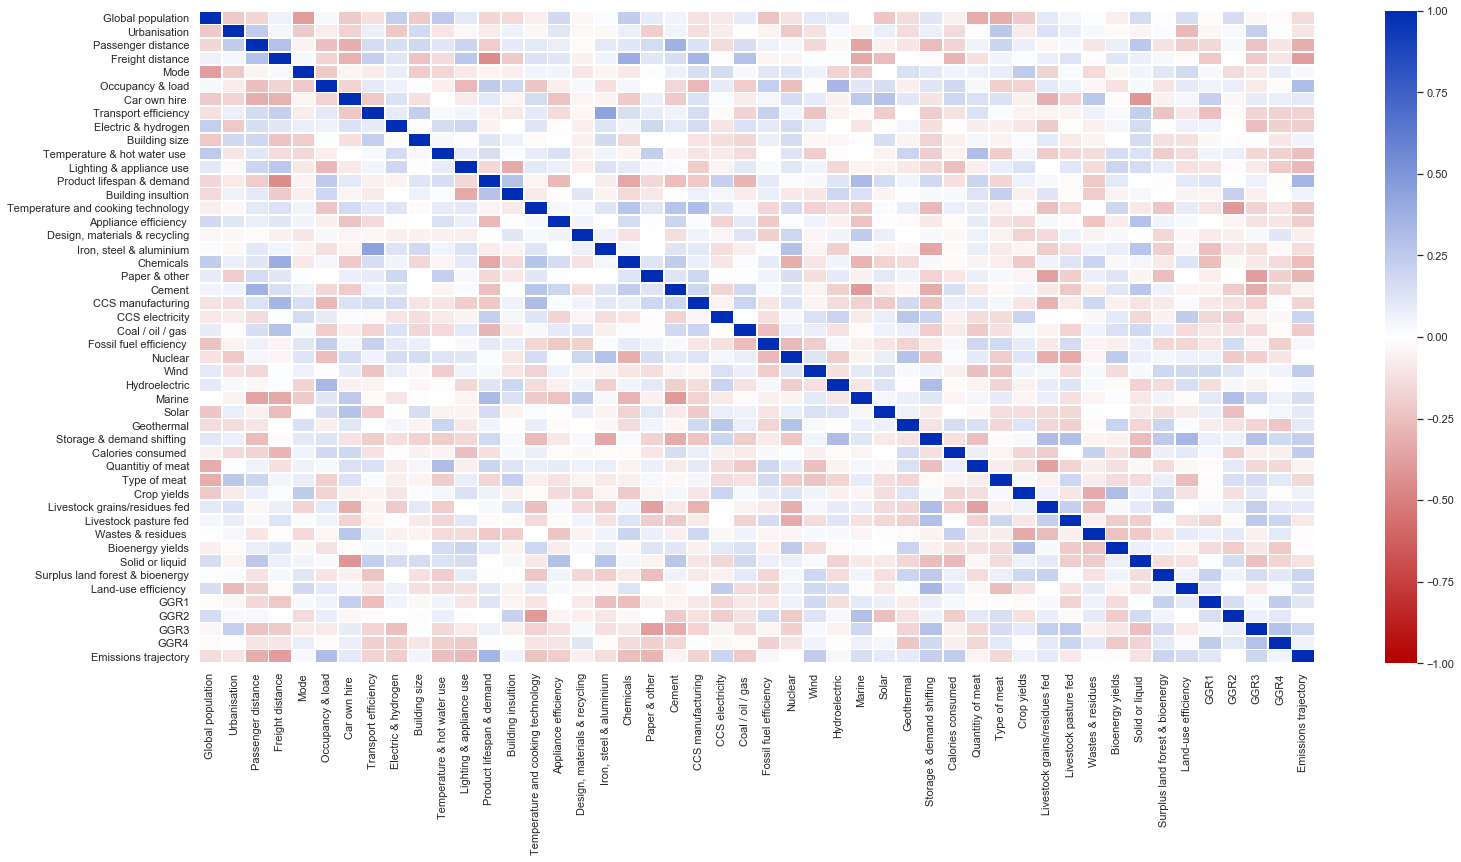

In [158]:
cov = dfs_4.iloc[:, :48].corr()
plt.figure(figsize = (25, 12))
sns.heatmap(
        vmin=-1.0,
        vmax=1.0,
        data=cov,
        cmap=cm,
        linewidths=0.75)

# Paired density and scatter plot matrix of lever combinations accepted by MCMC

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000172F76E6F08>,
      dtype=object)

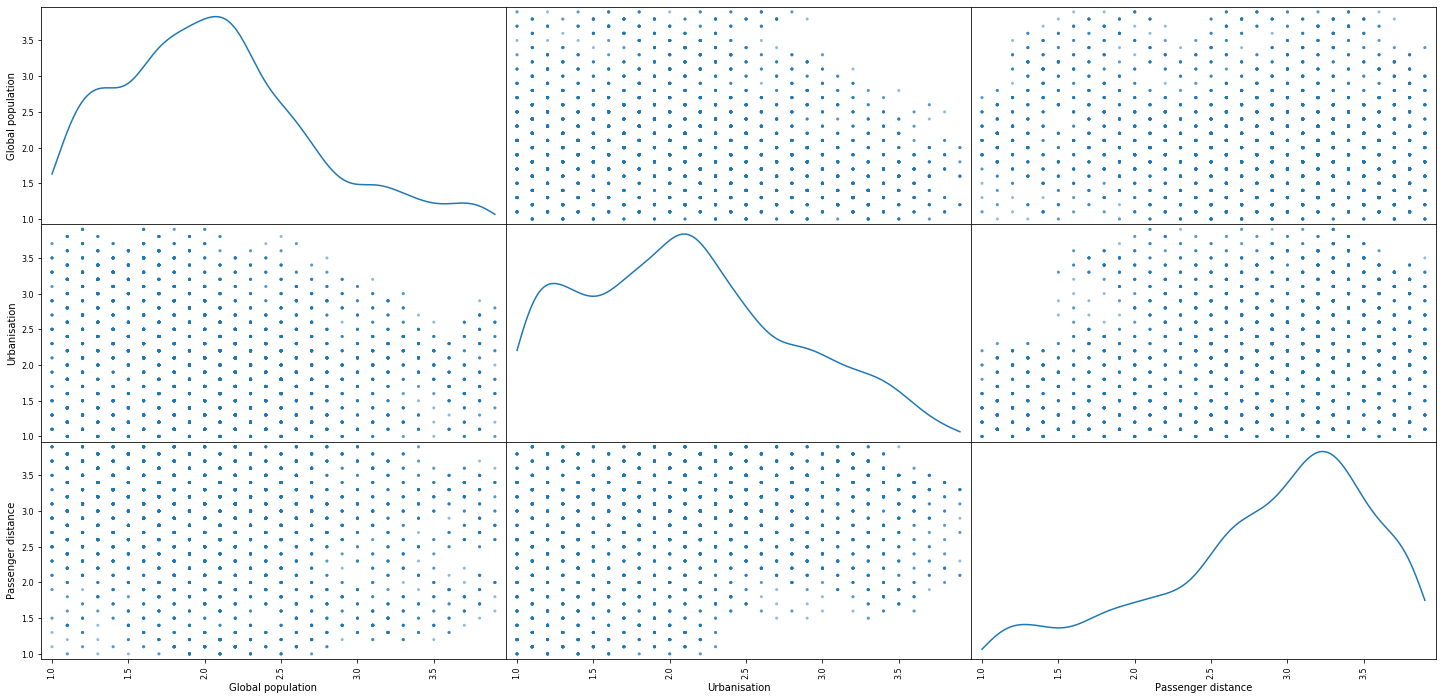

In [72]:
pd.plotting.scatter_matrix(dfs_4.iloc[:, :3], figsize  = [25, 12],
                               marker   = ".",
    diagonal = "kde")

In [56]:
dfs = pd.read_excel("excel_files/Output_map.xlsx") # file mapping output lever names to xpaths 

In [57]:
# Read output values
output_data = pd.read_excel("excel_files/training_test_set.xlsx") # file mapping lever names to xpaths
new_df=(output_data.iloc[:, 49:]-output_data.iloc[:, 49:].mean())/output_data.iloc[:, 49:].std()

In [59]:
# List outputs
dfs.iloc[:, 0].to_numpy()

array(['GHG emissions (t CO2e) per capita',
       'Cumulative emissions by 2100 (Gt CO2e)',
       'Population (billions of people)', '% population in urban areas',
       'Total energy supply (EJ / year)',
       'Total energy demand (EJ / year)',
       'Energy demand (kWh / capita / year)',
       'Proportion of primary energy from fossil fuels',
       'Bioenergy supply (EJ / year)',
       'Electricity demand (kWh / capita /year)', 'Wind capacity (GW)',
       'Solar capacity (GW)', 'Nuclear capacity (GW)',
       'Hydro-electric capacity (GW)', 'GGS for power (GW)',
       'Storage capacity (GW)',
       'Efficiency of CCS fossil fuel power generation',
       'Emissions intensity (global average g CO2e / kWh)',
       'Number of passenger vehicles on the road (thousands)',
       '% urban cars that are zero emission (electric/hydrogen)',
       'Efficiency of average global car (litres gasoline equivalent per 100km)',
       'Total domestic passenger km travelled each year per 

# Correlation matrix of output values

In [60]:
cols = dfs.iloc[:, 0].to_numpy()

In [61]:
for i in range(len(cols)):
    cols[i] = cols[i][0:30] + " ..."

In [62]:
new_df.columns = cols

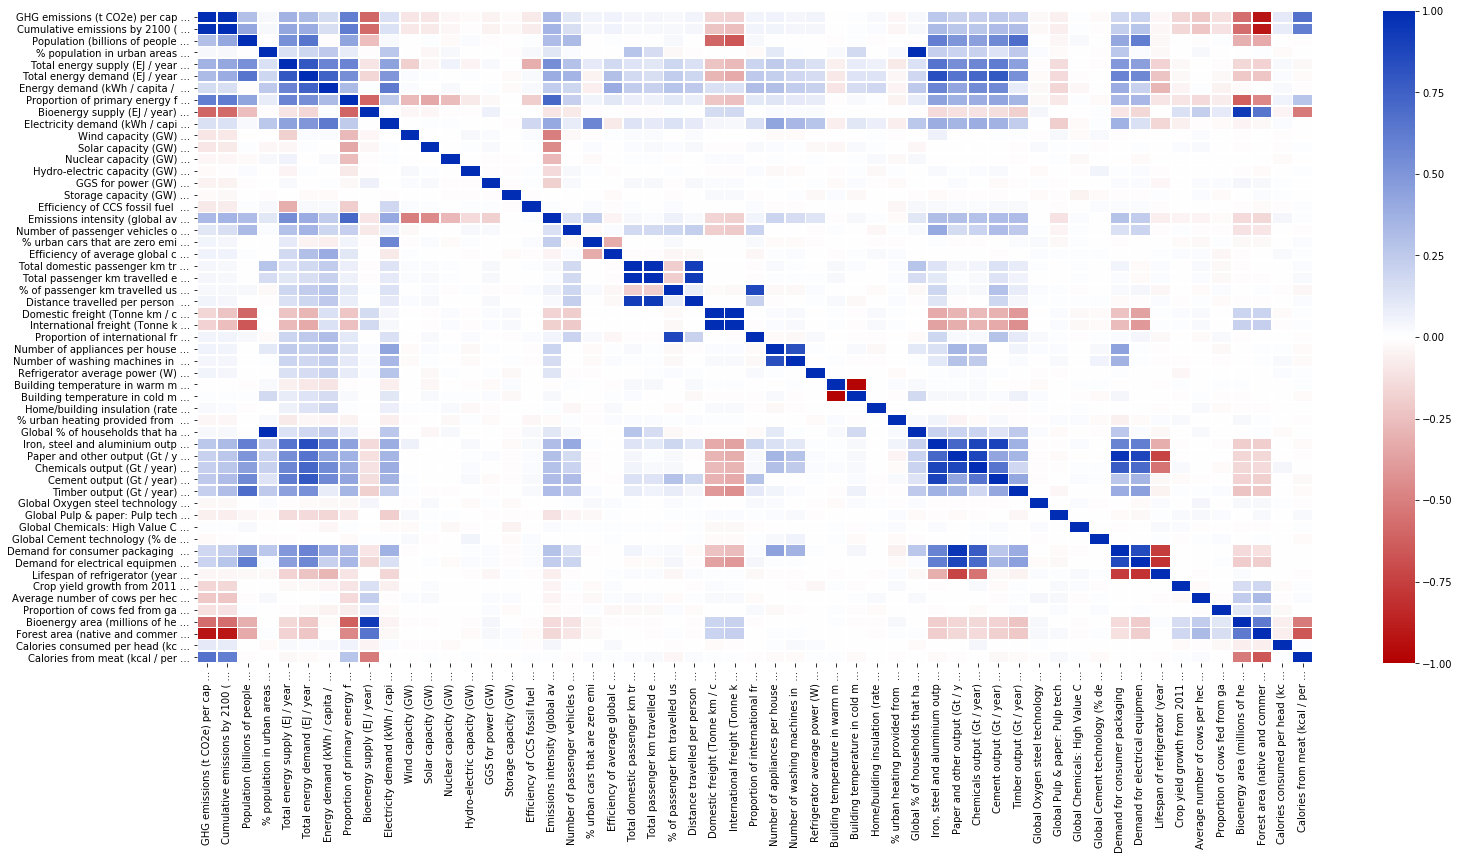

In [77]:
corr = new_df.corr()
plt.figure(figsize = (25, 12))
sns.heatmap(
        vmin=-1.0,
        vmax=1.0,
        data=corr,
        cmap=cm,
        linewidths=0.75)

# Export correlation data to GEPHI

In [174]:
# libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


#Calculate the correlation between individuals. We have to transpose first, because the corr function calculate the pairwise correlations between columns.
#corr = df.corr()
#corr = cov
 
# Transform it in a links data frame (3 columns only):
links = corr.stack().reset_index()
links.columns = ['var1', 'var2','value']
links
 
# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered= links.loc[ ((links['value'] < -0.23) & (links['var1'] != links['var2'])) | ((links['value']  > 0.23) & (links['var1'] != links['var2'])) > 0 ]
# links_filtered=links.loc[ (links['value'] < -0.7) & (links['var1'] != links['var2']) ]
links_filtered
 
# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2', edge_attr= 'value')
nx.write_gexf(G, "file_MCMC.gexf", version="1.2draft")
#nx.draw(G, with_labels=True, node_color='red', node_size=100, edge_color='black', linewidths=1, font_size=20)

In [ ]:
links_filtered

# Posterior distribution of accepted MCMC lever combinations

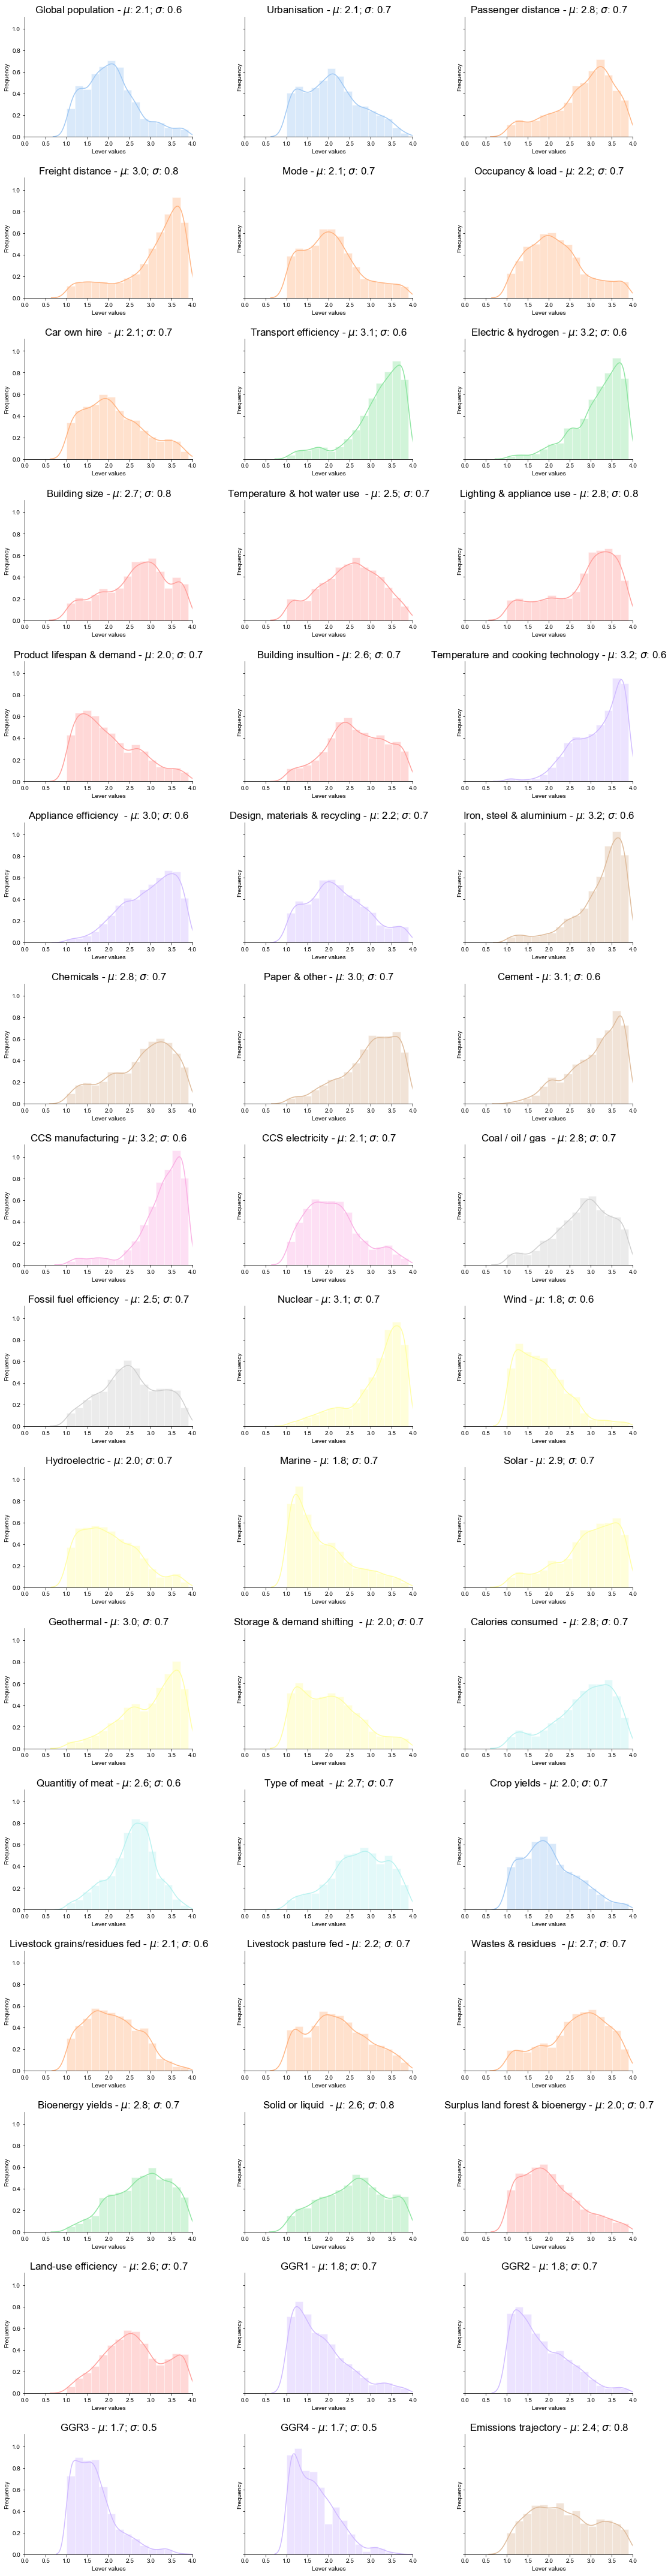

In [91]:
# Set figure and colour 
palette = itertools.cycle(sns.color_palette(palette = "pastel", n_colors = 16))
f, axes = plt.subplots(16, 3, figsize = (16, 60), sharey = True, sharex = False)
sns.despine(left=False)
row = 0; col = 0 # Indexes for subplots
c = next(palette)


rc={'axes.labelsize': 17, 'font.size': 17, 'legend.fontsize': 17.0, 'axes.titlesize': 17}
plt.rcParams.update(**rc)
sns.set(rc=rc)
sns.set_style(style='white')

#sns.set(font_scale=15)
# Iterate through all data
for i in range(len(dfs_4.iloc[0, :]) - 2):
    values = dfs_4.iloc[:, i]
    if i in [2, 7, 9, 14, 17, 21, 23, 25, 36, 32, 35, 39, 41, 43, 47]: # If the group of levers changes, change colour
        c = next(palette)
        
    # Plot histogram
    sns.distplot(values,  kde = True, bins = 15, ax=axes[row, col], color = c).set_title(lever_names[i] + " - $\mu$: "  + str(round(values.mean(), 1)) + "; $\sigma$: " + str(round(values.std(), 1)), fontsize=17)
    axes[row, col].set_xlim(0, 4)
    axes[row, col].set(xlabel='Lever values', ylabel='Frequency')
    #axes[row, col].xlabel('Lever values')
    #axes[row, col].ylabel('Frequency')
    # Set subplot indexes
    if col != 2: col += 1 # 
    else: col = 0; row += 1; 
    
plt.tight_layout()

# Posterior distribution of model outputs accepted by MCMC

In [28]:
# Read more output values
dfs_5 = pd.read_excel("MCMC_output_1.xlsx") 

# Discard first iterations of MCMC
dfs_5 = dfs_5[dfs_5.iloc[:, 0] > 2750]
dfs_5 = dfs_5[dfs_5.iloc[:, 0] < 3250]

(-2.5, 2.5)

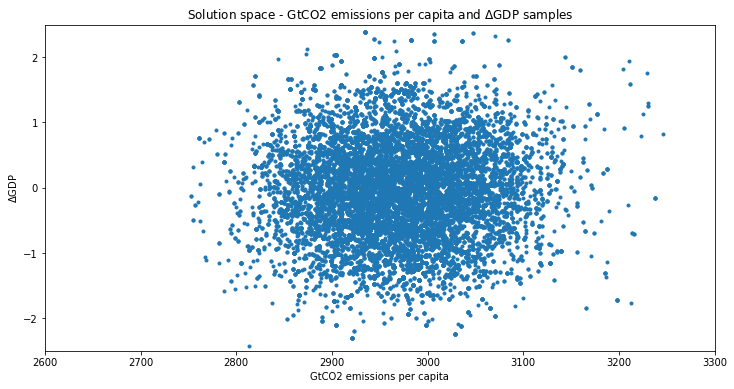

In [28]:
# Plotting routine
plt.figure(figsize = (12, 6))
plt.plot(dfs_5.iloc[:, 0], dfs_5.iloc[:, 1], '.')
plt.title("Solution space - GtCO2 emissions per capita and $\Delta$GDP samples")
plt.xlabel("GtCO2 emissions per capita")
plt.ylabel("$\Delta$GDP")
plt.xlim(2600, 3300)
plt.ylim(-2.5, 2.5)

In [29]:
# Construct dataframe for joint plot
data = dfs_5.iloc[:, 0:2]
data.columns = ['GtCO2 emissions per capita', '$\Delta$GDP']

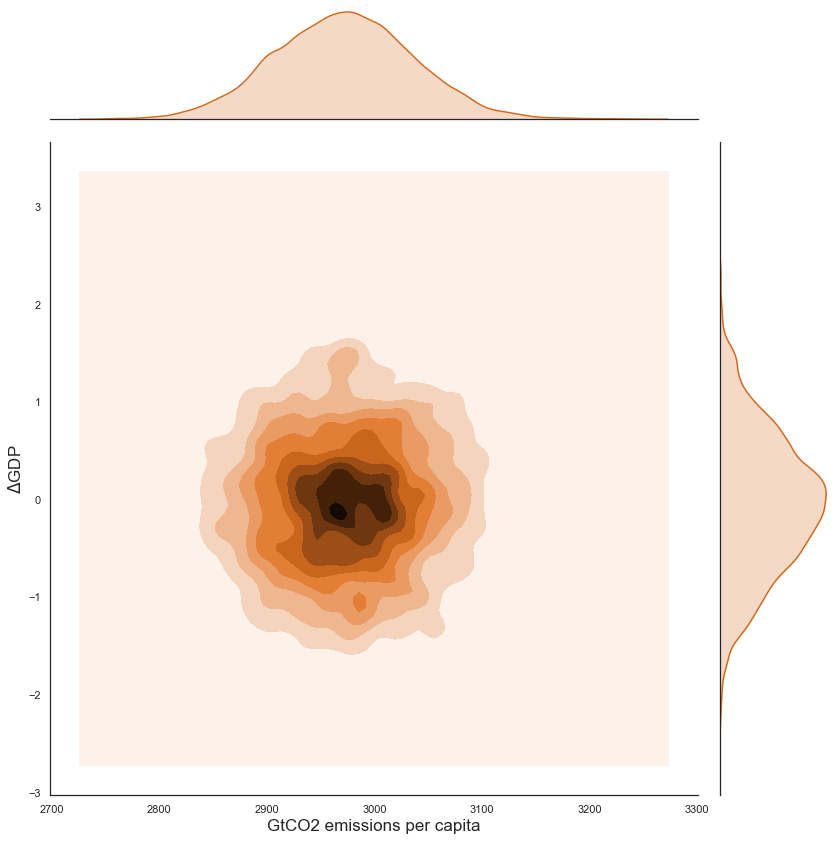

In [82]:
sns.jointplot("GtCO2 emissions per capita", "$\Delta$GDP", data=data, kind = "kde", height = 12, color = 'chocolate');

## Evolution of temperature values

(2700, 3300)

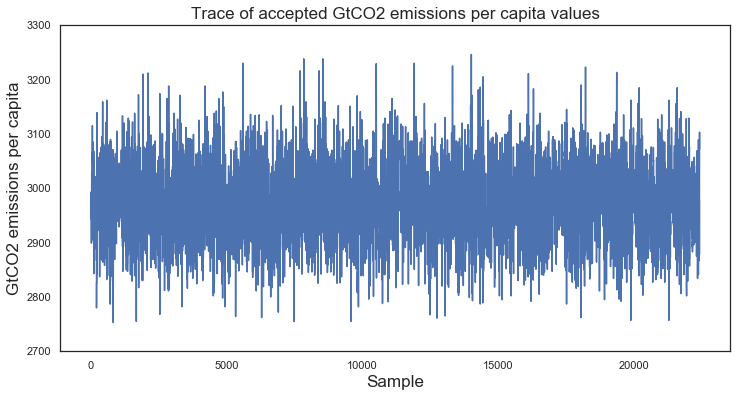

In [31]:
# Plotting routine
plt.figure(figsize = (12, 6))
plt.title("Trace of accepted GtCO2 emissions per capita values")
plt.xlabel("Sample")
plt.ylabel("GtCO2 emissions per capita")
plt.plot(dfs_5.iloc[:, 0])
plt.ylim(2700, 3300)

Mu:  2971.446327683616 ; Sigma:  73.90502290463505


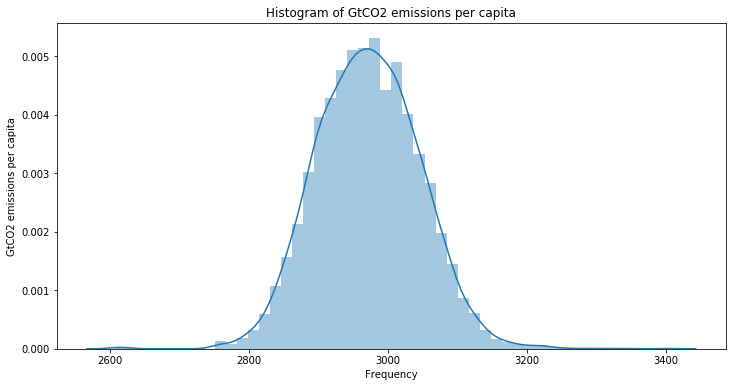

In [37]:
# Plotting routine 
plt.figure(figsize = (12, 6))
sns.distplot(dfs_4.iloc[:, -2])
plt.title("Histogram of GtCO2 emissions per capita")
plt.xlabel("Frequency")
plt.ylabel("GtCO2 emissions per capita")
print("Mu: ", dfs_4.iloc[:, -2].mean(), "; Sigma: ", dfs_4.iloc[:, -2].std())

## Evolution of cost values

(-2.5, 2.5)

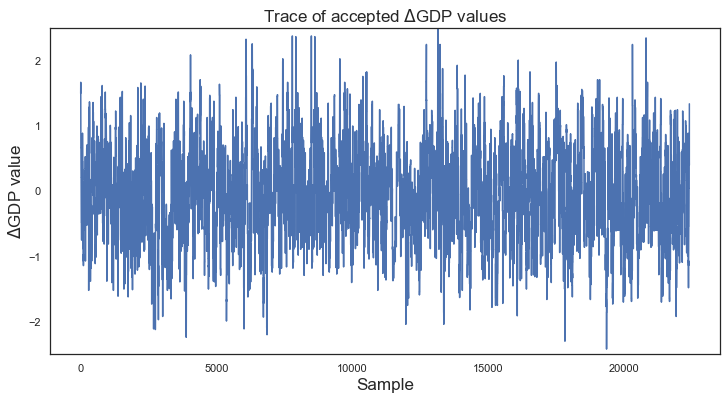

In [32]:
# Evolution of cost values
plt.figure(figsize = (12, 6))
plt.title("Trace of accepted $\Delta$GDP values")
plt.xlabel("Sample")
plt.ylabel("$\Delta$GDP value")
plt.plot(dfs_5.iloc[:, 1])
plt.ylim(-2.5, 2.5)

Mu:  -0.048114215910825986 ; Sigma:  0.728568148578964


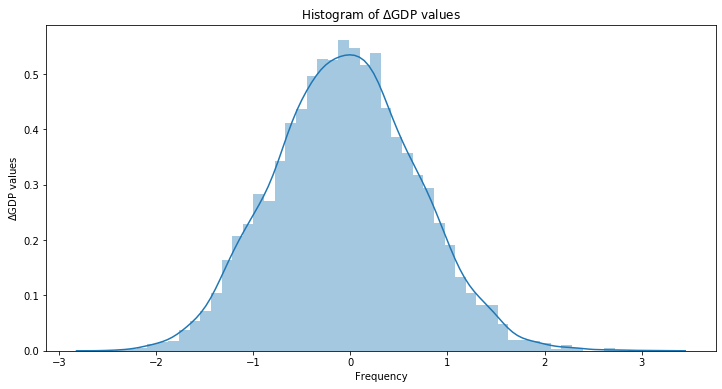

In [38]:
# Plotting routine
plt.figure(figsize = (12, 6))
sns.distplot(dfs_4.iloc[:, -1])
plt.title("Histogram of $\Delta$GDP values")
plt.xlabel("Frequency")
plt.ylabel("$\Delta$GDP values")
print("Mu: ", dfs_4.iloc[:, -1].mean(), "; Sigma: ", dfs_4.iloc[:, -1].std())

# Acceptance rate

(0, 10)

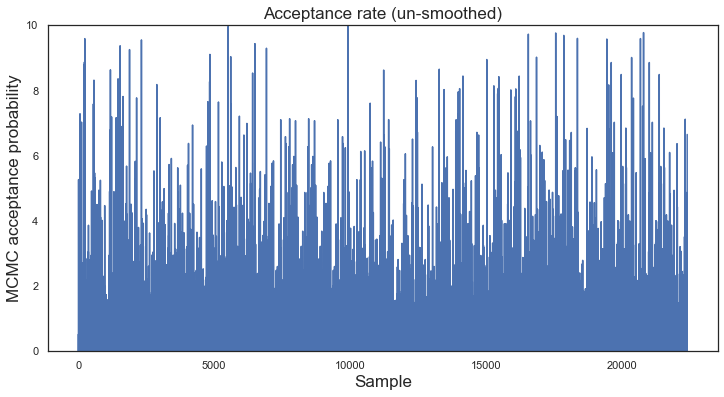

In [33]:
# Evolution of acceptance rate
dfs_5 = dfs_5[dfs_5.iloc[:, 2] < 10]
plt.figure(figsize = (12, 6))
plt.title("Acceptance rate (un-smoothed)")
plt.xlabel("Sample")
plt.ylabel("MCMC acceptance probability")
plt.plot(dfs_5.iloc[:, 2])
plt.ylim(0, 10)

In [34]:
def moving_average(a, n=3) :
    """Simple moving average filter"""
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [35]:
# Filter acceptance rate with MA filter (window length = 1000)
ma_rate = moving_average(dfs_5.iloc[:, 2].to_numpy(), n = 1000)

(0, 1)

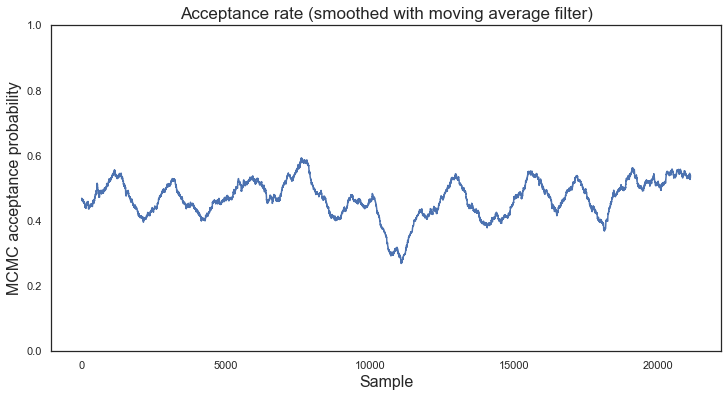

In [37]:
# Plotting routine
plt.figure(figsize = (12, 6))
plt.title("Acceptance rate (smoothed with moving average filter)")
plt.xlabel("Sample", fontsize = 16)
plt.ylabel("MCMC acceptance probability", fontsize = 16)
plt.plot(ma_rate)
plt.ylim(0, 1)

# Autocorrelation function of accepted model outputs

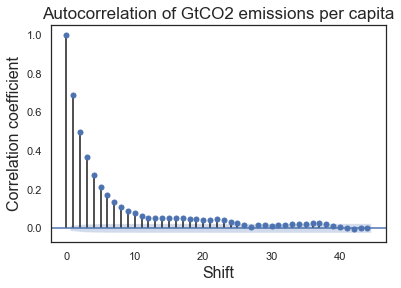

In [46]:
# Autocorrelation of temperature values
axes = plot_acf(dfs_5.iloc[:, 0])
plt.title("Autocorrelation of GtCO2 emissions per capita")
plt.xlabel("Shift", fontsize = 16)
plt.ylabel("Correlation coefficient", fontsize = 16)
plt.show()

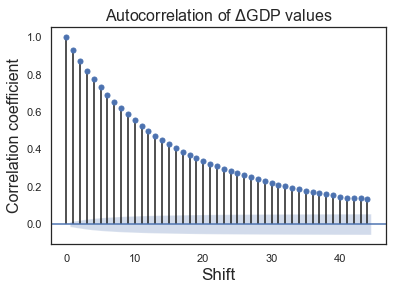

In [47]:
# Autocorrelation of cost values 
plot_acf(dfs_5.iloc[:, 1])
plt.title("Autocorrelation of $\Delta$GDP values", fontsize = 16)
plt.xlabel("Shift")
plt.ylabel("Correlation coefficient", fontsize = 16)
plt.show()

# Summary of inputs to the Global Calculator

In [189]:
for lever in dfs_3.iloc[:, 0]:
    print(lever)

Global population
Urbanisation
Passenger distance
Freight distance
Mode
Occupancy & load
Car own hire 
Transport efficiency
Electric & hydrogen
Building size
Temperature & hot water use 
Lighting & appliance use
Building insultion
Temperature and cooking technology
Appliance efficiency 
Product lifespan & demand
Design, materials & recycling
Iron, steel & aluminium
Chemicals
Paper & other
Cement
CCS manufacturing
CCS electricity
Coal / oil / gas 
Fossil fuel efficiency 
Nuclear
Wind
Hydroelectric
Marine
Solar
Geothermal
Storage & demand shifting 
Calories consumed 
Quantitiy of meat
Type of meat 
Crop yields
Livestock grains/residues fed
Livestock pasture fed
Wastes & residues 
Bioenergy yields
Solid or liquid 
Surplus land forest & bioenergy
Land-use efficiency 
GGR1
GGR2
GGR3
GGR4
Emissions trajectory
